# Config

In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cProfile
import pandas as pd
import geopandas as geopd
import json
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes
import src.utils.geometry as geo
import src.utils.make_config as make_config
import src.utils.scales as scales
import src.utils.places_to_cells as places_to_cells
import src.data.shp_extract as shp_extract
import src.data.metrics as metrics
import src.utils.places_to_cells as places_to_cells
import src.visualization.grid_viz as grid_viz
import src.visualization.helpers as helpers_viz
import src.models.mobility as mobility
from dotenv import load_dotenv
load_dotenv()
pd.reset_option("display.max_rows")

In [3]:
from matplotlib import font_manager
font_dirs = ["/home/thomaslouf/.fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [13]:
publication_plot = True
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=publication_plot)
if publication_plot:
    plt.rc('font', size=7)
    # Set to a column width, then to be adjusted by a factor.
    column_width_in = 8.7 / 2.54
    intercol_width_in = (17.8-8.7*2) / 2.54
    plt.rcParams["figure.figsize"] = (column_width_in, column_width_in*3/4)
else:
    plt.rc('font', size=11)
    plt.rcParams["figure.figsize"] = (10, 6)

for some reason locale encoding is ansi, but only in jupyter in this environmnent(??????)

In [4]:
data_dir_path = os.environ['DATA_DIR']
tweets_files_format = 'tweets_{}_{}_{}.json.gz'
places_files_format = 'places_{}_{}_{}.json.gz'
ssh_domain = os.environ['IFISC_DOMAIN']
ssh_username = os.environ['IFISC_USERNAME']
mapbox_token = os.environ['MAPBOX_TOKEN']
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')
latlon_proj = 'epsg:4326'
user_level_label = '{}-speakers'

country_codes = ('BE', 'BO', 'CA', 'CH', 'EE', 'ES', 'FR', 'HK', 'ID', 'LT', 
                 'LV', 'MY', 'PE', 'RO', 'SG', 'TN', 'UA')
with open(os.path.join(external_data_dir, 'countries.json'), encoding='utf-8') as f:
    countries_study_data = json.load(f)
with open(os.path.join(external_data_dir, 'langs_agg.json')) as f:
    langs_agg_dict = json.load(f)
fig_dir = os.path.join('..', 'reports', 'figures')
save_path_format = os.path.join(
    fig_dir, '{cc}', '{metric}', 
    '{metric}_{region}_{grp}cell_size={cell_size}m.pdf')

# Mixing metrics

In [5]:
count_dict = {'name': 'count', 'readable': 'Number', 'log_scale': True,
              'total_count_col': 'total_count', 'vmin': 1, 'cmap': 'Purples'}
repr_dict = {'name': 'repr', 'readable': 'Representation', 'log_scale': True,
             'total_count_col': 'total_count', 'sym_about': 1}
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
conc_dict = {'name': 'conc', 'readable': 'Concentration', 'log_scale': False, 
             'total_count_col': 'total_count'}
KL_dict = {'name': 'KL', 'readable': 'KL divergence', 'global_norm': True,
           'scale_fun': metrics.max_kl, 'log_scale': False,
           'total_count_col': 'total_count', 'sym_about': 0}
KL_props_dict = {'name': 'KL_props', 'readable': 'KL divergence', 'log_scale': False,
                 'total_count_col': 'local_count', 'cmap': 'Reds'}
Hc_dict = {'name': 'Hc', 'readable': 'Concentration entropy', 
           'scale_fun': metrics.null_Hc, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1, 
           'global_norm': False}
Hp_dict = {'name': 'Hp', 'readable': 'Relative proportion entropy', 
           'scale_fun': metrics.null_Hp, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1,
           'cbar_label': r'$H_i^p / H_{\mathrm{null}}^p$'}
EMD_dict = {'name': 'EMD', 'readable': "Earth mover's distance", 
           'log_scale': False, 'total_count_col': 'total_count'}
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}

Hc: the higher, the further from the null model, the less mixing. Pb: space not taken into account

pb with KL: when count of group is 0 (and total one isn't and is actually relevant), you get a divergence = 0, which doesn't make sense. Not a problem when there are users of this group in almost every cell, but can become one when too many relevant cells have a null count, like for multilingual groups

## Belgium

In [6]:
cc = 'BE'
region = None
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, 'Apn_AdRe.shp', 'Apn_AdRe.shp')
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=10**4, simplify_tol=50)

cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [86]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
fig, but = grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_zoom=7, alpha=0.8, mapbox_style='light', access_token=mapbox_token,
    plotly_renderer='iframe_connected', save_path=save_path, min_count=5, show=True)

/home/thomaslouf/Documents/code/multiling-twitter/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



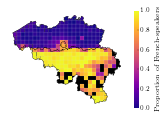

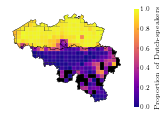

In [354]:
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
figsize = (17.8/3/2.54, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0)

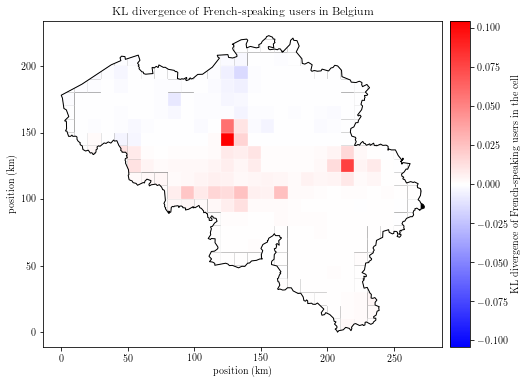

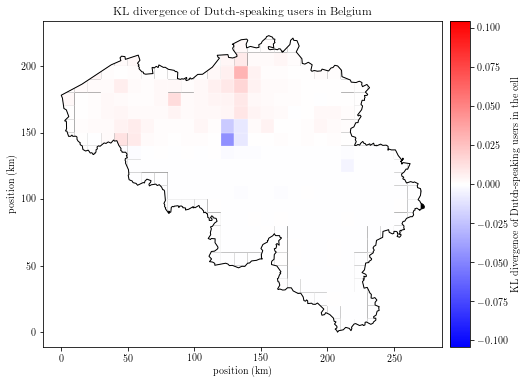

In [41]:
helpers_viz.metric_grid(
    cell_plot_df, KL_dict, shape_df, plot_langs_dict, 
    save_path_format=None, xy_proj=xy_proj, min_count=0, 
    null_color='k')

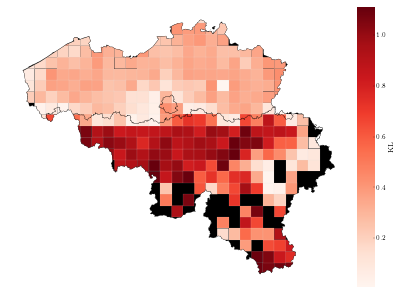

In [35]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}
metric_dict = KL_props_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
cbar_label = 'KL'
figsize = (16.8/3, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0, cbar_label=cbar_label)

In [37]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

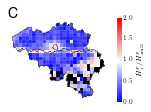

In [39]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
cbar_label = r'$H_i^p / H_{\mathrm{null}}^p$'
figsize = (16.8/3/2.54, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0, cbar_label=cbar_label)

In [32]:
grps_dict = plot_langs_dict
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Concentration entropy for the French-speaking users is: 0.12164586885380824.
The Concentration entropy for the Dutch-speaking users is: 0.007362814511328919.
The Concentration entropy averaged over all groups is 0.033141950498156506.
The KL divergence for the French-speaking users is: 0.9144480674305526.
The KL divergence for the Dutch-speaking users is: 0.4881675257308824.
The KL divergence averaged over all groups is 0.6799868421056324.


In [33]:
prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
             / cell_plot_df.shape[0])
print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)
emd_value, norm, d_matrix = metrics.earthmover_distance(
    cell_plot_df, plot_multi_mono_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=None)
print(emd_value, norm)

The ratio of cells with a null multilinguals' count is 0.2809917355371901
The Concentration entropy for the French-speaking users is: 0.12139989965299602.
The Concentration entropy for the Dutch-speaking users is: 0.007744109881952843.
The Concentration entropy averaged over all groups is 0.03327520933778848.
The KL divergence for the French-speaking users is: 0.9144480674305526.
The KL divergence for the Dutch-speaking users is: 0.4881675257308824.
The KL divergence averaged over all groups is 0.6799868421056324.
The EMD between the distributions of multilinguals and of the total population is 0.09488537391297433.
8017.897545548734 84500.87948119886


In [36]:
_, _, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=False)

grps_dict = plot_langs_dict
for grp, grp_dict in grps_dict.items():
    count_col = grp_dict['count_col']
    conc_col = grp_dict['conc_col']
    n_samples = cell_plot_df[count_col].sum()
    ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 'total_conc', 
                                           Nx, Ny, n_samples)
    print(grp, ks_score, p_value)
    chi2_score, normed_score, p_value = metrics.grid_chisquare(
        cell_plot_df, conc_col, 'total_conc', n_samples)
    print(grp, normed_score, p_value)

fr 0.40004168427350506 0.0
fr 1.2506201907608219 0.0
nl 0.2607372596337826 0.0
nl 0.40063598747136026 0.0


In [156]:
grps_dict = plot_lings_dict
Hp_global = metrics.all_cells_metric(Hp_dict, cell_plot_df)
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Proportion entropy averaged over all cells is 0.4368810060400594
The Concentration entropy for the French monolinguals is: 0.8722684620258012.
The Concentration entropy for the Dutch monolinguals is: 0.9992067419197258.
The Concentration entropy for the French-Dutch bilinguals is: 0.9009427309916483.
The Concentration entropy averaged over all groups is 0.9586006939822082.
The KL divergence for the French monolinguals is: 0.6409798716576481.
The KL divergence for the Dutch monolinguals is: 0.6926123752507499.
The KL divergence for the French-Dutch bilinguals is: 0.10808882065709233.
The KL divergence averaged over all groups is 0.6239909623935143.


Wouldnt log(repr) be better suited? Problem: cells with repr == 0 -> then clusters with entropy/KL div?

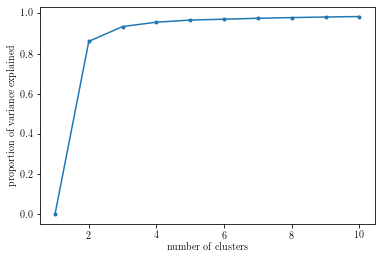

In [38]:
cols = [lang['repr_col'] for lang in plot_langs_dict.values()]
cells_vectors = cell_plot_df[cols].values
_, all_cells_clusters, _, ax = metrics.clusters(cells_vectors)

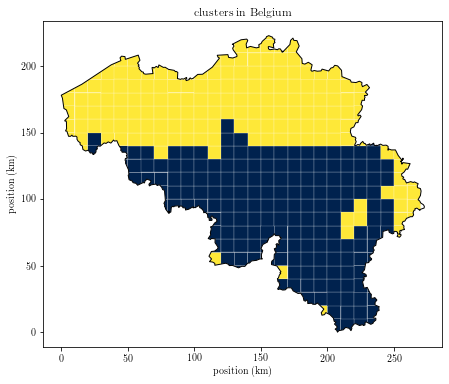

In [39]:
n_clusters_to_keep = 2
cell_plot_df['cluster'] = all_cells_clusters[n_clusters_to_keep-1]
plot_title = f'clusters in {area_name}'
cbar_label = None
plot_kwargs = {
    'title': plot_title, 'metric_col': 'cluster', 'cbar_label': cbar_label,
    'xy_proj': xy_proj, 'plot': {
        'edgecolor': 'w', 'linewidths': 0.2, 
        'cmap': cm.get_cmap('cividis', n_clusters_to_keep)}}
ax = grid_viz.plot_grid(
    cell_plot_df, shape_df, **plot_kwargs)

## Spain

In [36]:
cc = 'ES'
region = 'Catalonia'
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

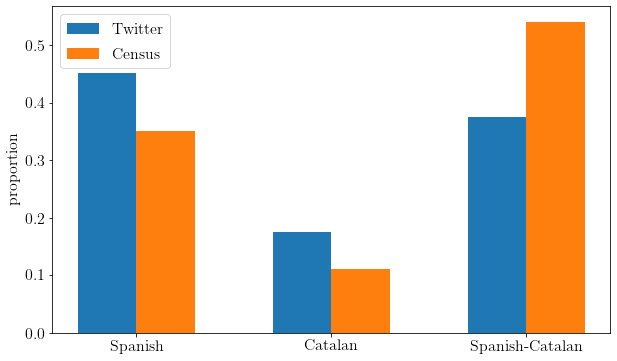

In [252]:
census_es_ratio = 0.35
census_ca_ratio = 0.11
census_caes_ratio = 1 - 0.11 - 0.35
census_ratios = [census_es_ratio, census_ca_ratio, census_caes_ratio]
total = cell_plot_df['local_count'].sum()
twitter_es_ratio = cell_plot_df['count_ling_es'].sum() / total
twitter_ca_ratio = cell_plot_df['count_ling_ca'].sum() / total
twitter_caes_ratio = cell_plot_df['count_ling_caes'].sum() / total
twitter_ratios = [twitter_es_ratio, twitter_ca_ratio, twitter_caes_ratio]
fig, ax = plt.subplots(1, figsize=(10, 6))
width = 0.3
xticks = np.array([1, 2, 3])
p1 = ax.bar(xticks, twitter_ratios, width)
p2 = ax.bar(xticks + width, census_ratios, width)

ax.set_xticks(xticks + width / 2)
ax.set_xticklabels(('Spanish', 'Catalan', 'Spanish-Catalan'))
ax.set_ylabel('proportion')
ax.legend((p1[0], p2[0]), ('Twitter', 'Census'))
ax.autoscale_view()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, cc, 'cat_twiter_vs_census_lingual_groups.pdf'))
plt.show()

In [172]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
fig = grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='light', mapbox_zoom=7, alpha=0.8, access_token=mapbox_token,
    plotly_renderer='iframe_connected', save_path=save_path, min_count=5)

/home/thomaslouf/Documents/code/multiling-twitter/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



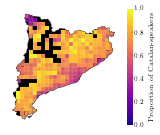

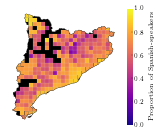

In [54]:
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
figsize = (17.8/3/2.54, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0)

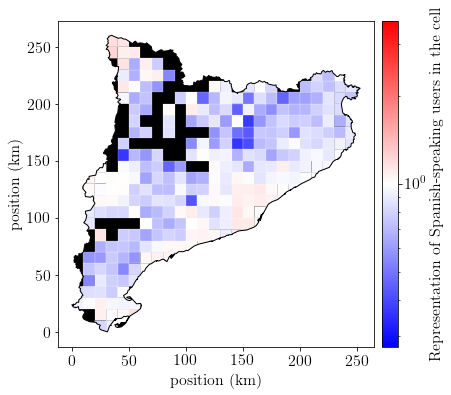

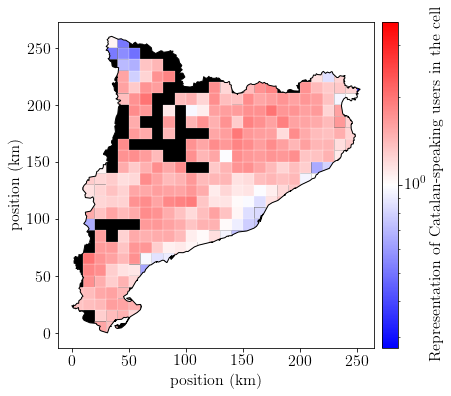

In [37]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

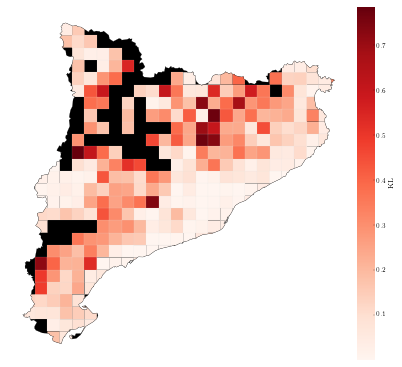

In [37]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}
metric_dict = KL_props_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
cbar_label = 'KL'
figsize = (16.8/3, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0, cbar_label=cbar_label)

In [46]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

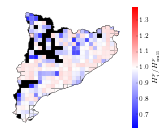

In [358]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
cbar_label = r'$H_i^p / H_{\mathrm{null}}^p$'
figsize = (17.8/3/2.54, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0, cbar_label=cbar_label)

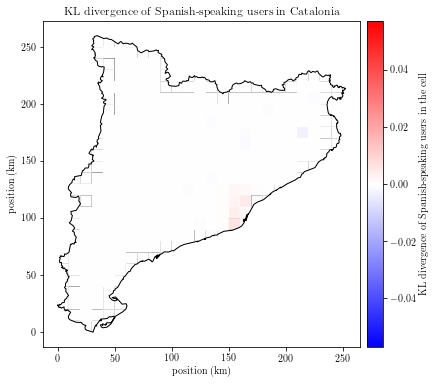

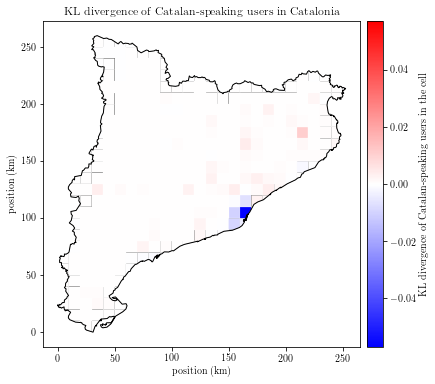

In [106]:
helpers_viz.metric_grid(
    cell_plot_df, KL_dict, shape_df, plot_langs_dict, 
    save_path_format=None, xy_proj=xy_proj, min_count=0, 
    null_color='k')

In [19]:
grps_dict = plot_langs_dict
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Concentration entropy for the Spanish-speaking users is: 0.9679253809940158.
The Concentration entropy for the Catalan-speaking users is: 1.1095512588663359.
The Concentration entropy averaged over all groups is 0.07585687977267806.
The KL divergence for the Spanish-speaking users is: 0.20385035633976598.
The KL divergence for the Catalan-speaking users is: 0.30519336556673904.
The KL divergence averaged over all groups is 0.29269155448624073.


In [90]:
prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
             / cell_plot_df.shape[0])
print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)
emd_value, norm, d_matrix = metrics.earthmover_distance(
    cell_plot_df, plot_multi_mono_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=None)
print(emd_value, norm)

The ratio of cells with a null multilinguals' count is 0.028795811518324606
The Concentration entropy for the Catalan monolinguals is: 0.20071843432296488.
The Concentration entropy for the Spanish monolinguals is: 0.09190087109163503.
The Concentration entropy for the multilinguals is: 0.040561471016655304.
The Concentration entropy averaged over all groups is 0.08904803379260717.
The KL divergence for the Catalan monolinguals is: 0.4294538773568471.
The KL divergence for the Spanish monolinguals is: 0.15684734755026322.
The KL divergence for the multilinguals is: 0.10493041326974215.
The KL divergence averaged over all groups is 0.1720533226062847.
The EMD between the distributions of multilinguals and of the total population is 0.031431978874803194.
2845.8695923934215 90540.57982568686


In [21]:
_, _, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=False)

grps_dict = plot_langs_dict
for grp, grp_dict in grps_dict.items():
    count_col = grp_dict['count_col']
    conc_col = grp_dict['conc_col']
    n_samples = cell_plot_df[count_col].sum()
    ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 'total_conc', 
                                           Nx, Ny, n_samples)
    print(grp, ks_score, p_value)
    chi2_score, normed_score, p_value = metrics.grid_chisquare(
        cell_plot_df, conc_col, 'total_conc', n_samples)
    print(grp, normed_score, p_value)

[0.15142930539887733, 0.1807604429764223, 0.14980980537434124, 0.14981020200442297]
mono_ling_ca 0.1807604429764223 0.0
mono_ling_ca 0.26861835026663344 0.0
[0.061688007467650685, 0.07638733620487093, 0.060773960035376495, 0.06075710531412143]
mono_ling_es 0.07638733620487093 3.3506051648624743e-226
mono_ling_es 0.05840672484100866 0.0
[0.03250623275719611, 0.038022372161026774, 0.028001223322509816, 0.02788038748522209]
multi 0.038022372161026774 5.1954061998951745e-36
multi 0.020215046879011232 8.264992734777066e-18


In [160]:
grps_dict = plot_lings_dict
Hp_global = metrics.all_cells_metric(Hp_dict, cell_plot_df)
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Proportion entropy averaged over all cells is 0.960887183121997
The Concentration entropy for the Catalan monolinguals is: 1.2010022023230005.
The Concentration entropy for the Spanish monolinguals is: 0.9082914308809532.
The Concentration entropy for the Catalan-Spanish bilinguals is: 1.0408714689430467.
The Concentration entropy averaged over all groups is 1.0135401750620867.
The KL divergence for the Catalan monolinguals is: 0.2609221887068473.
The KL divergence for the Spanish monolinguals is: 0.1803654539173365.
The KL divergence for the Catalan-Spanish bilinguals is: 0.085128700875913.
The KL divergence averaged over all groups is 0.1720533226062847.


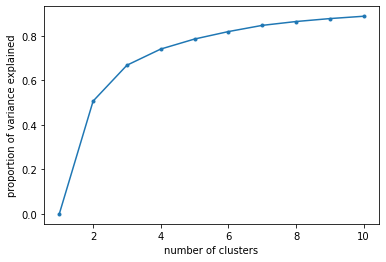

In [6]:
cols = [lang['repr_col'] for lang in plot_langs_dict.values()]
cells_vectors = cell_plot_df[cols].values
_, all_cells_clusters, _, ax = metrics.clusters(cells_vectors)

With 2 clusters, we explain just a bit more than 50% of the variance -> can illustrate qualitative difference bewteen cat and be or ch

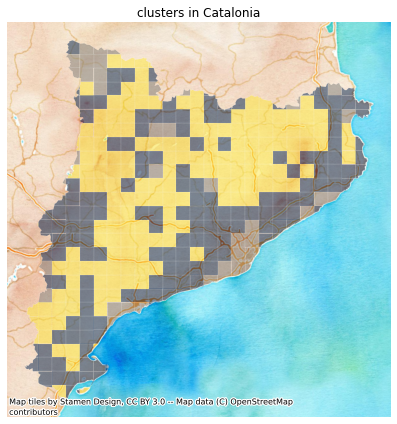

In [34]:
n_clusters_to_keep = 3
cell_plot_df['cluster'] = all_cells_clusters[n_clusters_to_keep-1]
plot_title = f'clusters in {area_name}'
cbar_label = None
# Avoid sequential colormaps starting or ending with white, as white is  
# reserved for an absence of data
plot_kwargs = {
    'title': plot_title, 'metric_col': 'cluster', 'cbar_label': cbar_label,
    'xy_proj': xy_proj, 'plot': {
        'edgecolor': 'w', 'linewidths': 0.2, 
        'cmap': cm.get_cmap('cividis', n_clusters_to_keep)}}
fig, ax = grid_viz.plot_grid(
    cell_plot_df, shape_df, figsize=(10,6),**plot_kwargs)

## Switzerland

In [16]:
cc = 'CH'
region = None
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [39]:
metric_dict = repr_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
fig = grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='light', mapbox_zoom=7, alpha=0.8, access_token=mapbox_token,
    plotly_renderer='iframe_connected', save_path=save_path, min_count=5)

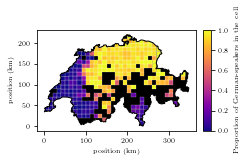

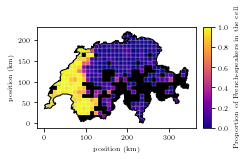

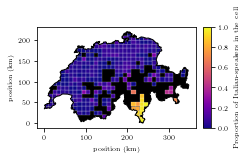

In [17]:
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
figsize=(8.7/2.54, 10)
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, figsize=figsize,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [26]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

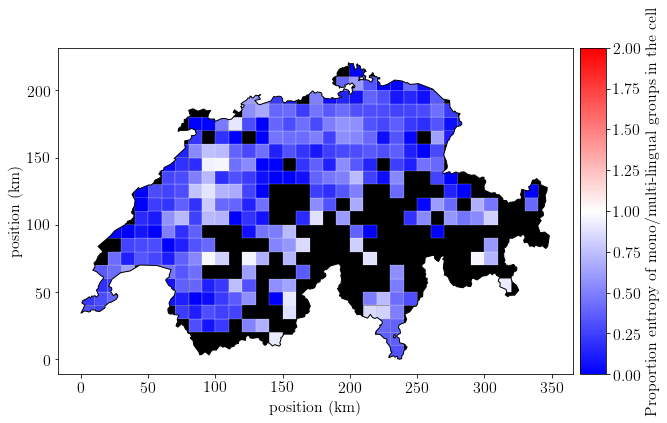

In [27]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

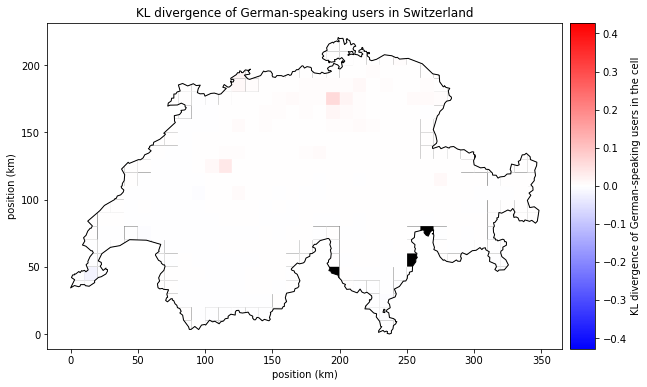

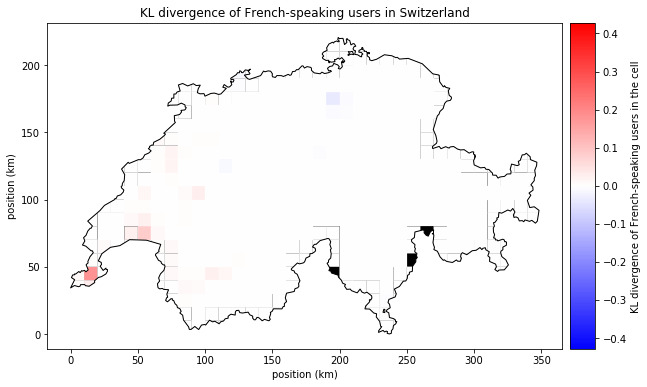

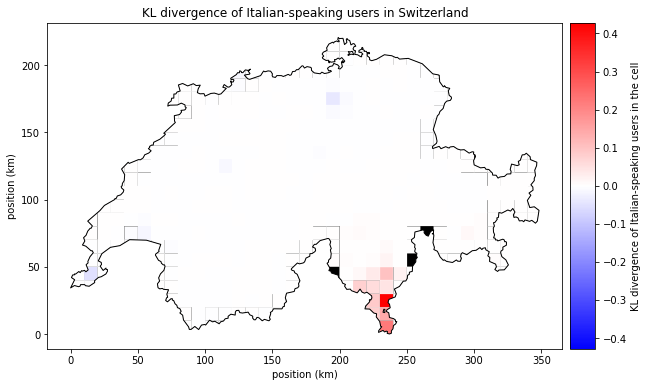

In [89]:
helpers_viz.metric_grid(
    cell_plot_df, KL_dict, shape_df, plot_langs_dict, 
    save_path_format=None, xy_proj=xy_proj, min_count=0, 
    null_color='k')

In [36]:
grps_dict = plot_langs_dict
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Concentration entropy for the German-speaking users is: 0.98499164504712.
The Concentration entropy for the French-speaking users is: 0.8259617306363651.
The Concentration entropy for the Italian-speaking users is: 0.8817308734347101.
The Concentration entropy averaged over all groups is 0.0527397210218581.
The KL divergence for the German-speaking users is: 0.4782027490018117.
The KL divergence for the French-speaking users is: 0.6454604111239606.
The KL divergence for the Italian-speaking users is: 0.5853167321112569.
The KL divergence averaged over all groups is 0.3185935414504748.


In [154]:
grps_dict = plot_lings_dict
Hp_global = metrics.all_cells_metric(Hp_dict, cell_plot_df)
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)

The Proportion entropy averaged over all cells is 0.3904249480526555
The Concentration entropy for the German monolinguals is: 0.9775722641769954.
The Concentration entropy for the French monolinguals is: 0.8079523621157346.
The Concentration entropy for the Italian monolinguals is: 0.8409376310165656.
The Concentration entropy for the German-French bilinguals is: 0.8593756621239426.
The Concentration entropy for the German-Italian bilinguals is: 0.9128091882191087.
The Concentration entropy for the French-Italian bilinguals is: 0.7500031836600045.
The Concentration entropy for the German-French-Italian trilinguals is: 0.501637060477667.
The Concentration entropy averaged over all groups is 0.8912178800999762.
The KL divergence for the German monolinguals is: 0.4549299719673681.
The KL divergence for the French monolinguals is: 0.628967450302419.
The KL divergence for the Italian monolinguals is: 0.6250579132789522.
The KL divergence for the German-French bilinguals is: 0.2001113510206

In [37]:
prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
             / cell_plot_df.shape[0])
print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
Hc_global, grps_dict = metrics.all_grps_metric(Hc_dict, cell_plot_df, grps_dict,
                                               cell_size=cell_size)
KL, grps_dict = metrics.all_grps_metric(KL_dict, cell_plot_df, grps_dict)
emd_value, norm, d_matrix = metrics.earthmover_distance(
    cell_plot_df, plot_multi_mono_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=None)
print(emd_value, norm)

The ratio of cells with a null multilinguals' count is 0.48268839103869654
The Concentration entropy for the German monolinguals is: 0.023289675017457157.
The Concentration entropy for the French monolinguals is: 0.19444814998989646.
The Concentration entropy for the Italian monolinguals is: 0.16533724915730752.
The Concentration entropy for the multilinguals is: 0.02835129805367631.
The Concentration entropy averaged over all groups is 0.057094292399672945.
The KL divergence for the German monolinguals is: 0.6293310808415099.
The KL divergence for the French monolinguals is: 0.951508688867573.
The KL divergence for the Italian monolinguals is: 1.9179800128201494.
The KL divergence for the multilinguals is: 0.6663183444303225.
The KL divergence averaged over all groups is 0.5261005738368818.
The EMD between the distributions of multilinguals and of the total population is 0.18079793117393853.
20930.20603482003 115765.73857299233


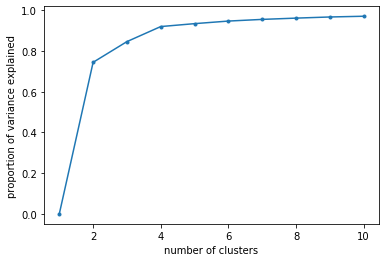

In [10]:
cols = [lang['repr_col'] for lang in plot_langs_dict.values()]
cells_vectors = cell_plot_df[cols].values
_, all_cells_clusters, _, ax = metrics.clusters(cells_vectors)

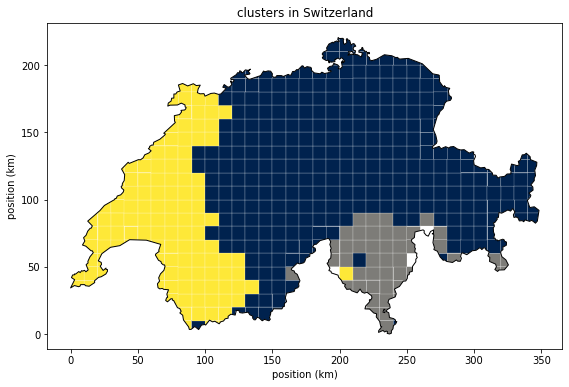

In [11]:
n_clusters_to_keep = 3
cell_plot_df['cluster'] = all_cells_clusters[n_clusters_to_keep-1]
plot_title = f'clusters in {area_name}'
cbar_label = None
# Avoid sequential colormaps starting or ending with white, as white is  
# reserved for an absence of data
plot_kwargs = dict(edgecolor='w', linewidths=0.2, 
                   cmap=cm.get_cmap('cividis', n_clusters_to_keep))
plot_kwargs = {
    'title': plot_title, 'metric_col': 'cluster', 'cbar_label': cbar_label,
    'xy_proj': xy_proj, 'plot': {
        'edgecolor': 'w', 'linewidths': 0.2, 
        'cmap': cm.get_cmap('cividis', n_clusters_to_keep)}}
ax = grid_viz.plot_grid(
    cell_plot_df, shape_df, **plot_kwargs)

## Quebec

In [213]:
cc = 'CA'
region = 'Quebec'
cell_size = 20000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
# Using knowledge of languages data
sum_ling = 3586410 + 372450 + 4032635
plot_lings_dict['ling_fr']['ratio'] = 4032635 / sum_ling
plot_lings_dict['ling_en']['ratio'] = 372450 / sum_ling
plot_lings_dict['ling_enfr']['ratio'] = 3586410 / sum_ling
lings = list(plot_lings_dict.keys())

shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
cells_df, cells_in_area_df, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=True)
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=5,
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

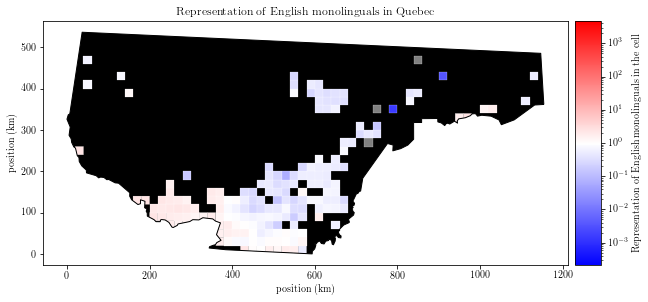

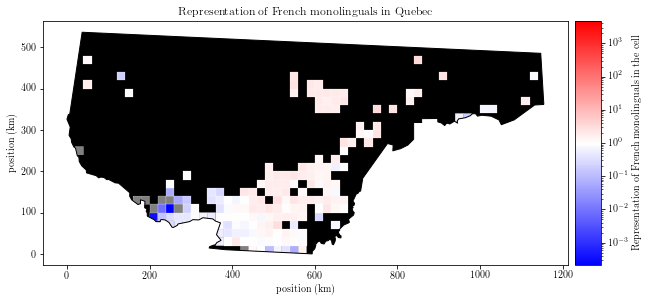

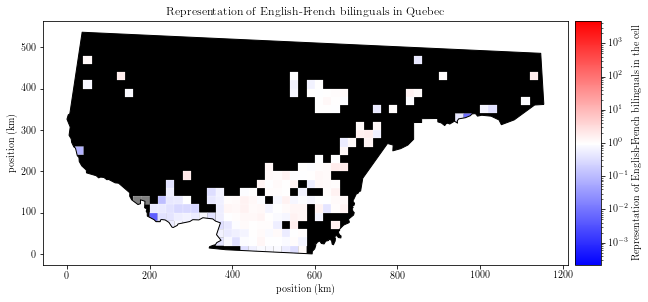

In [172]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [169]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

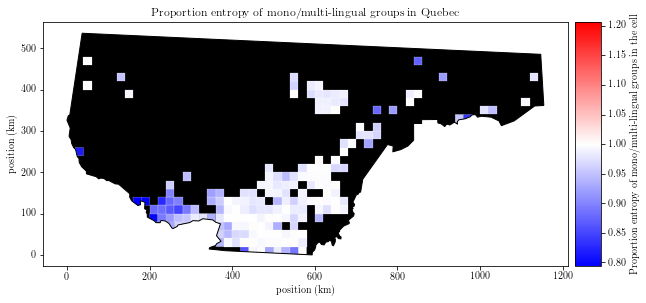

In [170]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

Here: test to add cells with 0 pop, and see how it affects the two normed EMD

--> test conclusive by using min of total conc to weigh the norm. Could also simply calculate the norm on non empty cells (pb: many cells with barely 0 but not 0), then put a threshold, but that's maybe just pushing back the pb without eliminating it

In [14]:
new_cells, _, _, _ = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=False)

In [15]:
a = new_cells.join(cell_plot_df[['conc_fr', 'conc_en', 'total_conc']])
a.loc[a['conc_fr'].isnull(), 'conc_fr'] = 0
a.loc[a['conc_en'].isnull(), 'conc_en'] = 0
a.loc[a['total_conc'].isnull(), 'total_conc'] = 0
emd_value, norm, d_matrix = metrics.earthmover_distance(
    a, plot_langs_dict['fr']['conc_col'], plot_langs_dict['en']['conc_col'], d_matrix=None)
print(emd_value / np.mean(d_matrix))
print(emd_value / norm)
print(emd_value, norm, np.mean(d_matrix))

0.11071694747442906
0.19331547011000164
50759.36949008027 262572.72354456084 458460.70224979374


### Census language data pre processing

In [402]:
import zipfile
with zipfile.ZipFile(os.path.join(external_data_dir, "98-400-X2016348_ENG_CSV.ZIP")) as z:
    for filename in z.namelist():
        if filename == '98-400-X2016348_English_CSV_data.csv':
            with z.open(filename) as f:
                cols = pd.read_csv(f, nrows=2).columns
                usecols = ['GEO_CODE (POR)', 'GEO_LEVEL'] + [col for col in cols if col.startswith('DIM') or bool(col.find('Total')+1)]
                ling_census_df = pd.read_csv(f, skiprows=1674752, header=None, names=cols, nrows=4119502-1674752,
                                             usecols=usecols)
ling_census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2444750 entries, 0 to 2444749
Data columns (total 7 columns):
 #   Column                                                                                                    Dtype 
---  ------                                                                                                    ----- 
 0   GEO_CODE (POR)                                                                                            int64 
 1   GEO_LEVEL                                                                                                 int64 
 2   DIM: Other language(s) spoken regularly at home (11)                                                      object
 3   DIM: Knowledge of official languages (5)                                                                  object
 4   DIM: Age (7)                                                                                              object
 5   DIM: First official language spoken (5)                  

In [403]:
age_mask = ling_census_df['DIM: Age (7)'].str.startswith('Total - ')
other_lang_mask = ling_census_df['DIM: Other language(s) spoken regularly at home (11)'].str.startswith('Total - ')
first_lang_mask = ling_census_df['DIM: First official language spoken (5)'].str.startswith('Total - ')
geo_level_mask = ling_census_df['GEO_LEVEL'] == 3
filtered_df = ling_census_df.loc[
    age_mask & other_lang_mask & first_lang_mask & geo_level_mask, 
    ['GEO_CODE (POR)', 'DIM: Knowledge of official languages (5)',
     'Dim: Language spoken most often at home (10): Member ID: [1]: Total - Language spoken most often at home']]
filtered_df.columns = pd.Index(['id', 'ling', 'value'])
filtered_df.head()

id                                     ling  value
2323  2401023  Total - Knowledge of official languages  11890
2358  2401023                             English only    120
2393  2401023                              French only   9095
2428  2401023                       English and French   2670
2463  2401023               Neither English nor French      0

In [404]:
pivoted_df = filtered_df.pivot(index='id', columns='ling', values='value')
pivoted_df = pivoted_df.rename(columns={'English and French': 'ling_enfr', 
                                        'English only': 'ling_en', 
                                        'French only': 'ling_fr'})
pivoted_df['local_count'] = pivoted_df['ling_enfr'] + pivoted_df['ling_en'] + pivoted_df['ling_fr']
for ling in ['ling_fr', 'ling_en', 'ling_enfr']:
    pivoted_df['prop_'+ling] = pivoted_df[ling] / pivoted_df['local_count']
    pivoted_df = pivoted_df.rename(columns={ling: 'count_'+ling})
pivoted_df = pivoted_df.drop(columns=['Neither English nor French', 'Total - Knowledge of official languages'])
pivoted_df.head()

ling     count_ling_enfr  count_ling_en  count_ling_fr  local_count  \
id                                                                    
2401023             2670            120           9095        11885   
2401042              140            315             15          470   
2402005              840            385           1855         3080   
2402010               90              5            910         1005   
2402015              435              5           2970         3410   

ling     prop_ling_fr  prop_ling_en  prop_ling_enfr  
id                                                   
2401023      0.765250      0.010097        0.224653  
2401042      0.031915      0.670213        0.297872  
2402005      0.602273      0.125000        0.272727  
2402010      0.905473      0.004975        0.089552  
2402015      0.870968      0.001466        0.127566

Language census data have fewer municipalities which are basically deserts, mostly located in the north of Quebec

Differences only due to rounding at the next or previous multiple of 5 by the statistical office.

In [1318]:
pivoted_df.to_csv(os.path.join(external_data_dir, 'quebec_2016_csd_ling.csv'))

### Census CSD results

In [8]:
shapefile_name = 'lcsd000b16a_e.shp' # 'lcd_000b16a_e.shp'
shapefile_path = os.path.join(external_data_dir, shapefile_name, shapefile_name)
muni_shapes = geopd.read_file(shapefile_path)
muni_shapes = (muni_shapes.loc[muni_shapes['PRUID'] == '24']
                          .rename(columns={'CSDUID': 'muni_id'})
#                           .rename(columns={'CDUID': 'muni_id'})
                          .to_crs(xy_proj)
                          .astype({'muni_id': int})
                          .set_index('muni_id', drop=False))
muni_shapes['area'] = muni_shapes.geometry.area
muni_shapes.crs = xy_proj
muni_shapes.head()

muni_id                CSDNAME CSDTYPE PRUID           PRNAME CDUID  \
muni_id                                                                        
2404030  2404030              La Martre      MÉ    24  Quebec / Québec  2404   
2404037  2404037  Sainte-Anne-des-Monts       V    24  Quebec / Québec  2404   
2407080  2407080           Val-Brillant      MÉ    24  Quebec / Québec  2407   
2404025  2404025                Marsoui      VL    24  Quebec / Québec  2404   
2411010  2411010     Saint-Jean-de-Dieu      MÉ    24  Quebec / Québec  2411   

                    CDNAME CDTYPE   CCSUID             CCSNAME ERUID  \
muni_id                                                                
2404030  La Haute-Gaspésie    MRC  2404047            Cap-Chat  2410   
2404037  La Haute-Gaspésie    MRC  2404047            Cap-Chat  2410   
2407080       La Matapédia    MRC  2407080        Val-Brillant  2415   
2404025  La Haute-Gaspésie    MRC  2404047            Cap-Chat  2410   
2411010        Les Basques    MRC  2411010  Saint-Jean-de-Dieu  2415   

                                 ERNAME SACCODE SACTYPE CMAUID CMAPUID  \
muni_id                                                                  
2404030  Gaspésie--Îles-de-la-Madeleine     997       5   None    None   
2404037  Gaspésie--Îles-de-la-Madeleine     998       6   None    None   
2407080               Bas-Saint-Laurent     997       5   None    None   
2404025  Gaspésie--Îles-de-la-Madeleine     998       6   None    None   
2411010               Bas-Saint-Laurent     997       5   None    None   

        CMANAME CMATYPE                                           geometry  \
muni_id                                                                      
2404030    None    None  POLYGON ((173364.308 581279.439, 174022.384 57...   
2404037    None    None  POLYGON ((161685.821 574869.261, 164427.058 57...   
2407080    None    None  POLYGON ((72228.069 505121.025, 72956.031 5046...   
2404025    None    None  POLYGON ((181975.328 583051.748, 182595.158 57...   
2411010    None    None  POLYGON ((-25655.531 444617.779, -23545.894 44...   

                 area  
muni_id                
2404030  1.762631e+08  
2404037  2.651508e+08  
2407080  9.198496e+07  
2404025  1.831028e+08  
2411010  1.525468e+08

In [9]:
ling_census_df = pd.read_csv(os.path.join(external_data_dir, 'quebec_2016_csd_ling.csv'), index_col='id')
ling_census_df.head()

count_ling_enfr  count_ling_en  count_ling_fr  local_count  \
id                                                                    
2401023             2670            120           9095        11885   
2401042              140            315             15          470   
2402005              840            385           1855         3080   
2402010               90              5            910         1005   
2402015              435              5           2970         3410   

         prop_ling_fr  prop_ling_en  prop_ling_enfr  
id                                                   
2401023      0.765250      0.010097        0.224653  
2401042      0.031915      0.670213        0.297872  
2402005      0.602273      0.125000        0.272727  
2402010      0.905473      0.004975        0.089552  
2402015      0.870968      0.001466        0.127566

In [225]:
max_y = (muni_shapes.loc[muni_shapes['CSDNAME'] == 'Passes-Dangereuses', 'geometry'].values[0].bounds[1])
max_x = muni_shapes.loc[muni_shapes['CSDNAME'] == 'Percé', 'geometry'].values[0].bounds[2]
to_keep = (muni_shapes.centroid.y < max_y) & (muni_shapes.centroid.x < max_x)
muni_ling = muni_shapes.loc[to_keep].join(ling_census_df.rename_axis('muni_id'), how='inner')
muni_ling['total_count'] = muni_ling['local_count']
# in pop / km**2
# muni_ling['density'] = (muni_ling['total_count'] / muni_ling['area']) * 10**6
muni_ling, plot_lings_dict = metrics.calc_by_cell(
    muni_ling, plot_lings_dict, cell_size=cell_size)

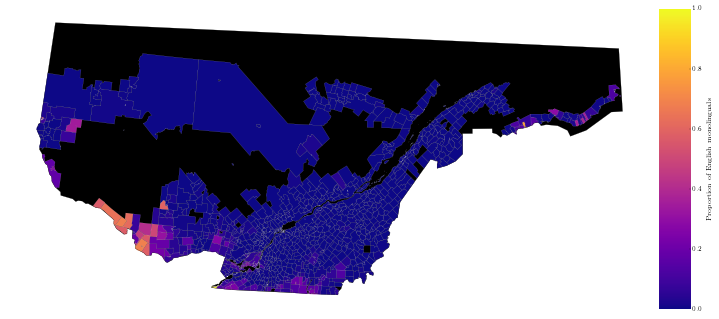

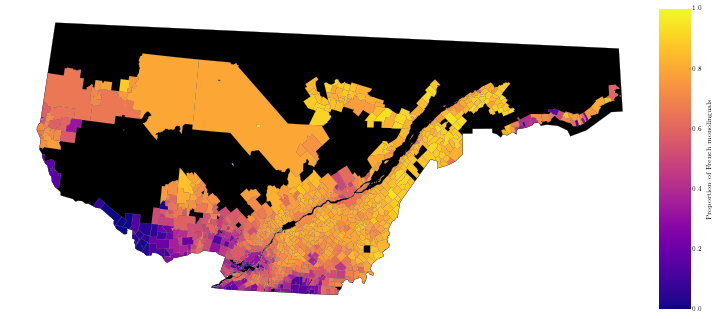

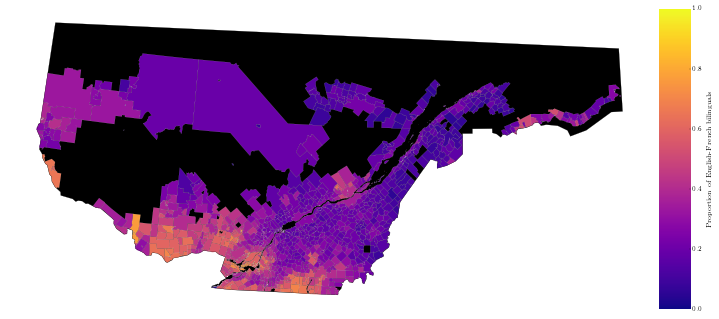

In [231]:
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
figsize = (10, 6) #(17.8/3/2.54, 10)
# muni_ling = muni_ling.loc[muni_ling['density'] > 1]
helpers_viz.metric_grid(
    muni_ling, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=100, null_color='k', figsize=figsize, cbar_lw=0)

muni_ling langs EMD

In [227]:
no_data = muni_ling['local_count'].isnull()
muni_ling['count_fr'] = muni_ling['count_ling_fr'] + muni_ling['count_ling_enfr']
muni_ling['count_en'] = muni_ling['count_ling_en'] + muni_ling['count_ling_enfr']

grps_dict = plot_langs_dict
muni_ling, grps_dict = metrics.calc_by_cell(
    muni_ling, grps_dict, cell_size=cell_size)
N = sum([muni_ling[f'count_{grp}'].sum() for grp in grps_dict])
EMD_langs = 0
d_matrix = None
res_dict = {'EMD_langs': 0}
for grp, grp_dict in grps_dict.items():
    N_grp = muni_ling[grp_dict['count_col']].sum()
    grp_label = grp_dict['grp_label']
    emd_value, norm, d_matrix = metrics.earthmover_distance(
        muni_ling, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
    res_dict[f'EMD_{grp}_vs_tot'] = emd_value/norm
    res_dict['EMD_langs'] += N_grp/N * emd_value/norm

### CSD to cells 

In [11]:
muni_in_cells = places_to_cells.get_intersect(
    muni_shapes[['muni_id', 'geometry', 'area']], cells_in_area_df)
muni_in_cells = muni_in_cells.set_index(['cell_id', 'muni_id'])[['ratio']]
muni_in_cells.head()

ratio
cell_id muni_id          
12      2485005  0.008760
13      2485005  0.075838
37      2485005  0.057040
38      2485005  0.263104
39      2485005  0.278883

In [12]:
muni_cells_ling = muni_in_cells.join(ling_census_df.rename_axis('muni_id'))

In [13]:
for ling in plot_lings_dict:
    muni_cells_ling['count_'+ling] *=  muni_cells_ling['ratio']
census_cell_plot_df = muni_cells_ling.groupby('cell_id')[['count_'+ling for ling in plot_lings_dict]].sum()

In [14]:
census_cell_plot_df['local_count'] = sum([census_cell_plot_df['count_'+ling] for ling in plot_lings_dict])
for ling in plot_lings_dict:
    census_cell_plot_df['prop_'+ling] = census_cell_plot_df['count_'+ling] / census_cell_plot_df['local_count']
census_cell_plot_df.head()

count_ling_en  count_ling_fr  count_ling_enfr  local_count  \
cell_id                                                               
12            3.723127       3.460318        13.928876    21.112322   
13           33.040867      34.815193       127.870786   195.726846   
14            4.256891     292.797746       112.106765   409.161402   
15            9.449518    2750.264217      1165.981227  3925.694962   
16           19.716232    1607.316823       663.857183  2290.890237   

         prop_ling_en  prop_ling_fr  prop_ling_enfr  
cell_id                                              
12           0.176349      0.163900        0.659751  
13           0.168811      0.177876        0.653312  
14           0.010404      0.715605        0.273992  
15           0.002407      0.700580        0.297013  
16           0.008606      0.701612        0.289781

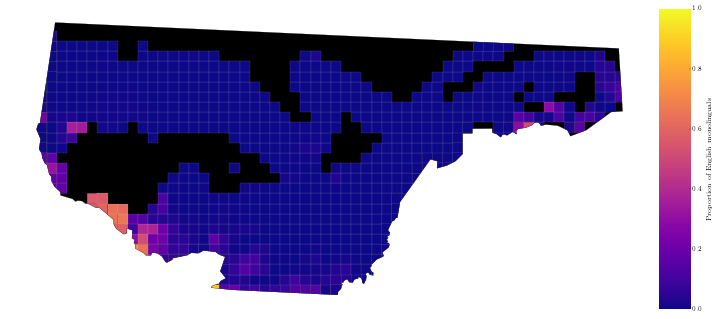

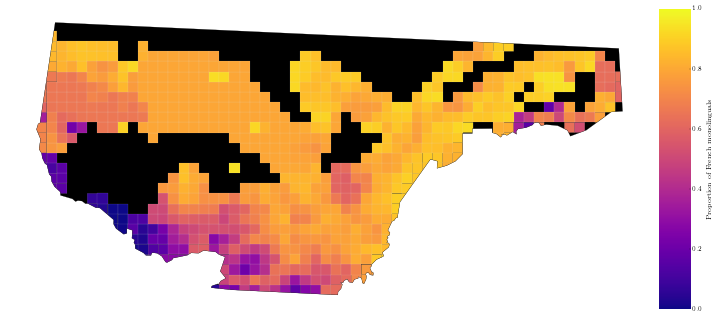

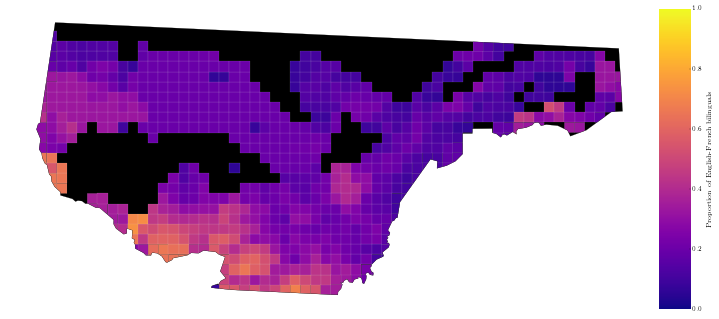

In [109]:
census_cell_plot_df['total_count'] = census_cell_plot_df['local_count']
census_cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    census_cell_plot_df, plot_lings_dict, cell_size=cell_size)
census_cell_plot_df = cells_in_area_df.join(census_cell_plot_df)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
figsize = (10, 6) #(17.8/3/2.54, 10)
# muni_ling = muni_ling.loc[muni_ling['density'] > 1]
helpers_viz.metric_grid(
    census_cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0)

### Rescaled Twitter vs census

In [26]:
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
rescale_df = census_cell_plot_df['local_count'].to_frame()
cell_plot_df = mobility.rescale_data(cell_plot_df, rescale_df, plot_lings_dict)
for ling in plot_lings_dict:
    count_col = 'count_' + ling
    cell_plot_df['prop_' + ling] = cell_plot_df[count_col] / cell_plot_df['local_count']
    cell_plot_df['conc_' + ling] = cell_plot_df[count_col] / cell_plot_df[count_col].sum()
cell_plot_df.head()

count_ling_en  count_ling_fr  count_ling_enfr  \
cell_id                                                  
39         1071.620808       0.000000       395.486637   
74           67.825562    1799.169482       728.281057   
77          177.768919    4017.534581      3706.424402   
183         187.377379     604.668320      4350.923227   
208         185.704641    1669.291802      1376.407414   

                                                  geometry  local_count  \
cell_id                                                                   
39       POLYGON ((-810566.145 377179.444, -790566.145 ...  1467.107445   
74       POLYGON ((-790566.145 537179.444, -770566.145 ...  2595.276100   
77       POLYGON ((-790566.145 597179.444, -770566.145 ...  7901.727902   
183      POLYGON ((-710566.145 557179.444, -690566.145 ...  5142.968925   
208      POLYGON ((-690566.145 517179.444, -670566.145 ...  3231.403858   

         total_count  cell_id  prop_ling_en  conc_ling_en  prop_ling_fr  \
cell_id                                                                   
39       1467.107445       39      0.730431      0.003167      0.000000   
74       2595.276100       74      0.026134      0.000200      0.693248   
77       7901.727902       77      0.022497      0.000525      0.508437   
183      5142.968925      183      0.036434      0.000554      0.117572   
208      3231.403858      208      0.057469      0.000549      0.516584   

         conc_ling_fr  prop_ling_enfr  conc_ling_enfr  
cell_id                                                
39           0.000000        0.269569        0.000121  
74           0.000491        0.280618        0.000224  
77           0.001097        0.469065        0.001138  
183          0.000165        0.845994        0.001335  
208          0.000456        0.425947        0.000422

TODO: put result in SI?

In [67]:
(census_cell_plot_df['prop_ling_enfr']*census_cell_plot_df['local_count']).sum() / census_cell_plot_df['local_count'].sum()

0.45116839254927243

In [66]:
((census_cell_plot_df - cell_plot_df)['prop_ling_enfr'].abs()*census_cell_plot_df['local_count']).sum() / census_cell_plot_df['local_count'].sum()

0.07775286224472143

In [53]:
min_count = 5
grps_dict = plot_lings_dict
plot_config = {i: None for i in range(6)}
list_grps = list(grps_dict.keys())
plot_prop_dict = prop_dict.copy()
# plot_prop_dict['cbar_label'] = ''
for k in range(3):
    plot_config[k] = {
            'cell_plot_df': muni_ling.copy(), 'shape_df': shape_df, 
            'metric_dict': plot_prop_dict, 'xy_proj': xy_proj,
            'grps_dict': grps_dict, 'grp': list_grps[k]}
    plot_config[k+3] = {
            'cell_plot_df': cell_plot_df.copy(), 'shape_df': shape_df, 
            'metric_dict': plot_prop_dict, 'xy_proj': xy_proj,
            'grps_dict': grps_dict, 'grp': list_grps[k]}
    
annotate_kwargs = {'fontfamily': 'Helvetica', 'fontsize': 14,
                   'usetex': False}
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.05, 'cmap': 'plasma'}
annotations = [chr(i).upper() for i in range(ord('a'), ord('z')+1)]
axes_dict = {}
for i, config in plot_config.items():
    ax_dict = {'figsize': (8.5/2.54, 5.9/2.54), 'borderwidth': 0.2,
               'cbar_lw': 0, 'annotation': annotations[i],
               'xy_proj': config['xy_proj'], 'annotate': annotate_kwargs,
#                'title': grps_dict[list_grps[i%3]]['readable'],
               'plot': plot_kwargs.copy()}
    axes_dict[i] = helpers_viz.axis_config(ax_dict, config, min_count=min_count)
for i in range(3):
    axes_dict[i]['cbar_label'] = ''
    axes_dict[i]['plot']['rasterized'] = True
#     axes_dict[i]['plot']['linewidths'] = 0.001
#     axes_dict[i]['title'] = grps_dict[list_grps[i%3]]['readable']

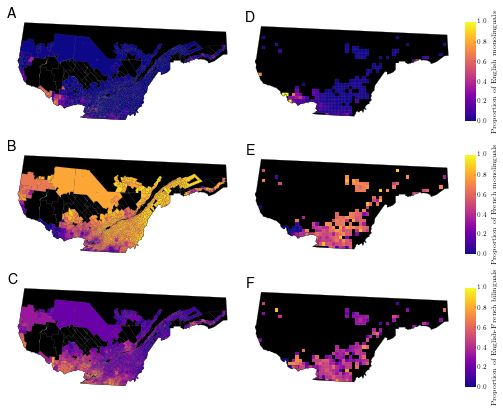

In [54]:
nr_rows = 3
nr_cols = 2
fig, axes = plt.subplots(nr_rows, nr_cols, figsize=(17.8/2.54, 24/2.54))
for i, ax in enumerate(axes.T.flatten()):
    cell_plot_df = plot_config[i]['cell_plot_df']
    shape_df = plot_config[i]['shape_df']
    fig, ax = grid_viz.plot_grid(cell_plot_df, shape_df, ax=ax, fig=fig,
                                 **axes_dict[i])
fig.tight_layout(h_pad=15, w_pad=2)
fig.savefig(os.path.join(fig_dir, cc, 'comp_prop_qbc.pdf'), bbox_inches='tight', dpi=600)
fig.show()

In [55]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
for df in (muni_ling, cell_plot_df):
    df[count_col] = 0
    for ling, ling_dict in plot_lings_dict.items():
        if len(ling.split('_')[1]) > 2:
            df[count_col] += df[ling_dict['count_col']]
    df, grps_dict = metrics.calc_by_cell(
        df, grps_dict, cell_size=cell_size)
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}

min_count = 5
list_grps = list(grps_dict.keys())
plot_config = {
    0: {
        'cell_plot_df': muni_ling.copy(), 'shape_df': shape_df,
        'metric_dict': Hp_dict, 'xy_proj': xy_proj,
        'grps_dict': mono_multi_lings_dict, 'grp': 'mono-multi'},
    1: {
        'cell_plot_df': cell_plot_df.copy(), 'shape_df': shape_df,
        'metric_dict': Hp_dict, 'xy_proj': xy_proj,
        'grps_dict': mono_multi_lings_dict, 'grp': 'mono-multi'}
}
annotate_kwargs = {'fontfamily': 'Helvetica', 'fontsize': 14,
                   'usetex': False}
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.1, 'cmap': 'plasma'}
annotations = [chr(i).upper() for i in range(ord('a'), ord('z')+1)]
axes_dict = {}
for i, config in plot_config.items():
    ax_dict = {'figsize': (17.8/2.54, 10), 'borderwidth': 0.2,
               'cbar_lw': 0, 'annotation': annotations[i],
               'xy_proj': config['xy_proj'], 'annotate': annotate_kwargs,
#                'title': grps_dict[list_grps[i%3]]['readable'],
               'plot': plot_kwargs.copy()}
    axes_dict[i] = helpers_viz.axis_config(ax_dict, config, min_count=min_count)
# axes_dict[0]['null_color'] = 'none
axes_dict[0]['plot']['rasterized'] = True

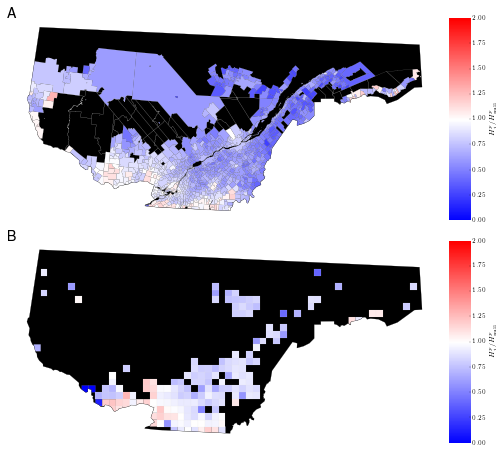

In [57]:
nr_rows = 2
nr_cols = 1
fig, axes = plt.subplots(nr_rows, nr_cols, figsize=(17.8/2.54, 24/2.54))
for i, ax in enumerate(axes.flatten()):
    cell_plot_df = plot_config[i]['cell_plot_df']
    shape_df = plot_config[i]['shape_df']
    fig, ax = grid_viz.plot_grid(cell_plot_df, shape_df, ax=ax, fig=fig,
                                 **axes_dict[i])
fig.tight_layout(h_pad=0, w_pad=2)
fig.savefig(os.path.join(fig_dir, cc, 'comp_Hp_qbc.pdf'), bbox_inches='tight', dpi=600)
fig.show()

## US

In [21]:
cc = 'US'
region = 'New York City'
cell_size = 2000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = repr_dict
metric = metric_dict['name']
file_name = f'lang_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_langs_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=8,
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

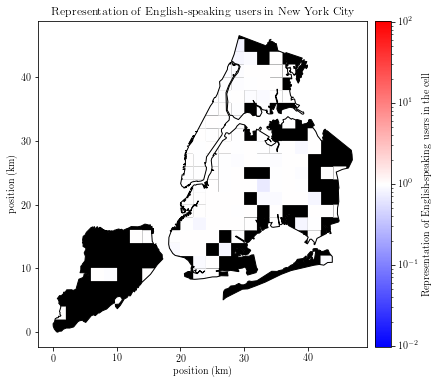

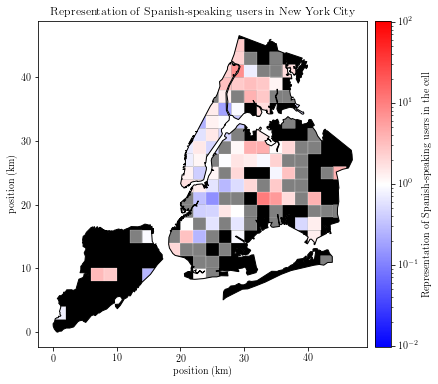

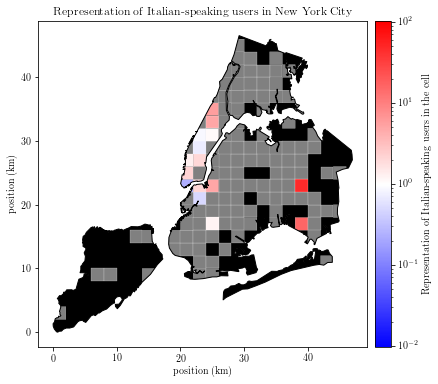

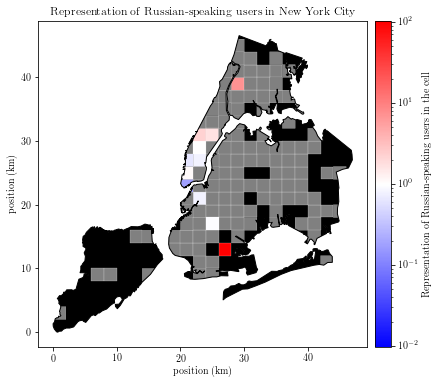

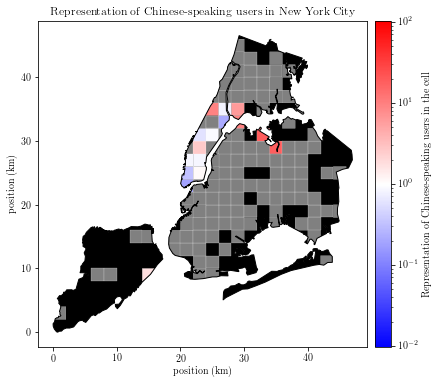

In [23]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_langs_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [24]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

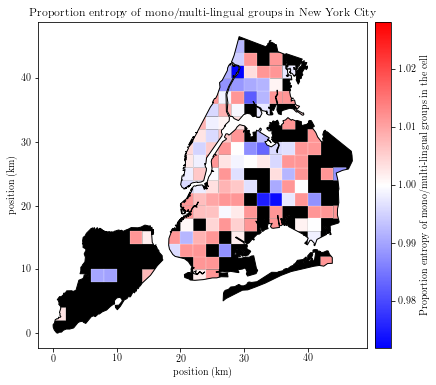

In [25]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

## Malaysia

In [173]:
cc = 'MY'
region = None
cell_size = 20000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [ ]:
metric_dict = prop_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=4,
    plotly_renderer='iframe_connected', save_path=save_path, show=False)

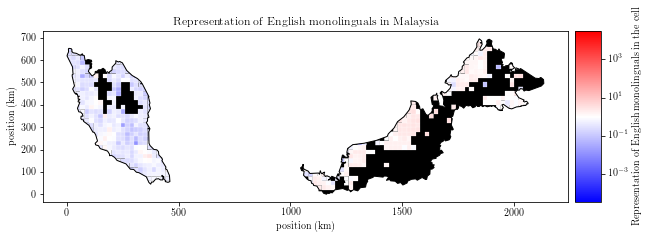

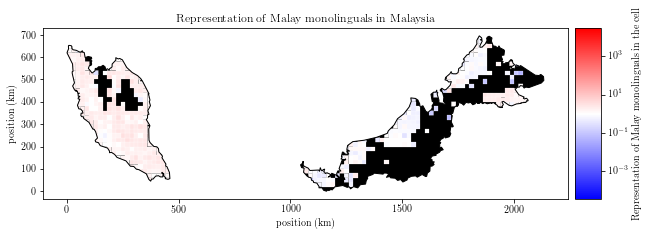

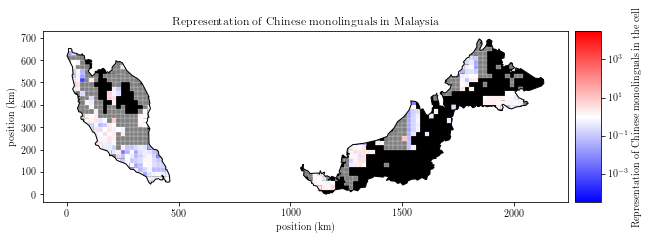

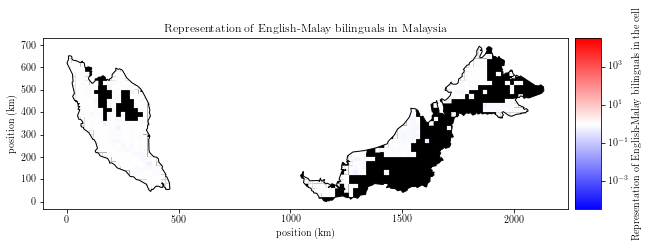

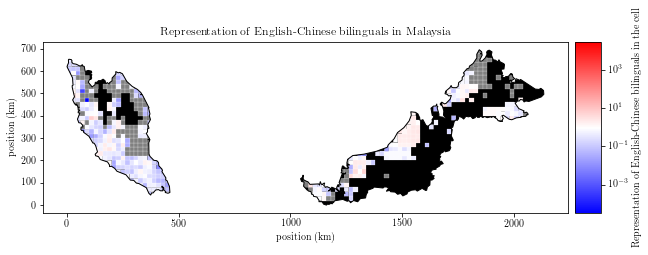

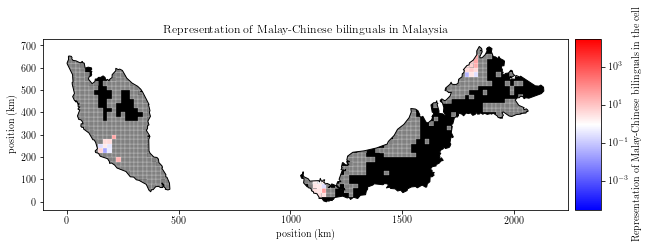

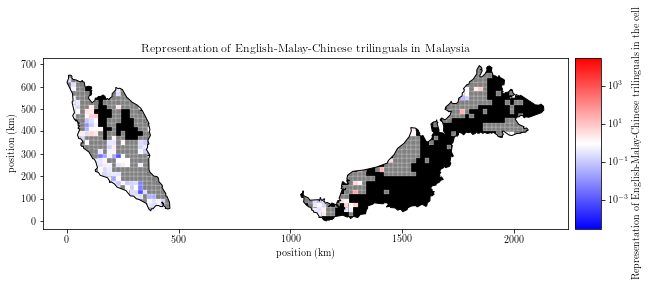

In [179]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [176]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

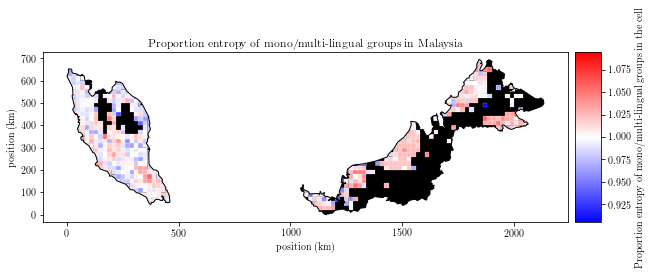

In [177]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

## Others

In [326]:
cc = 'CY'
region = None
cell_size = 5000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
min_poly_area = area_dict.get('min_poly_area')
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
    
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
    cell_plot_df, plot_langs_dict, cell_size=cell_size)
cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
    cell_plot_df, plot_lings_dict, cell_size=cell_size)

In [329]:
metric_dict = count_dict
metric = metric_dict['name']
file_name = f'ling_{metric}_{area_name}_cell_size={cell_size}m.html'
save_path = os.path.join(fig_dir, cc, metric, file_name)
grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_lings_dict, metric_dict,
    mapbox_style='stamen-toner', mapbox_zoom=7,
    plotly_renderer='iframe_connected', save_path=save_path, show=True)

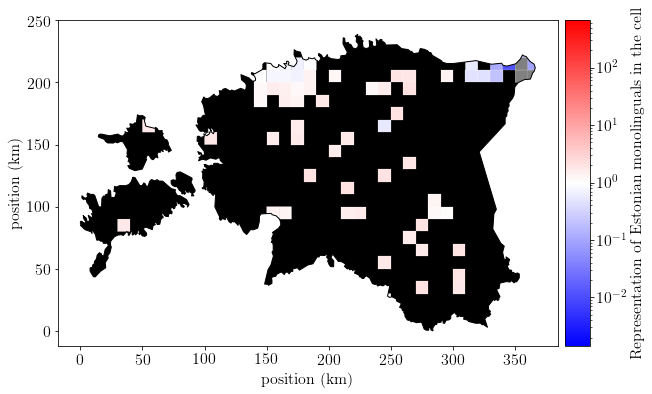

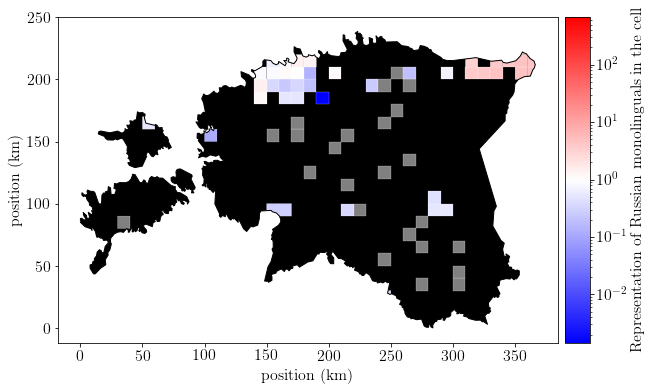

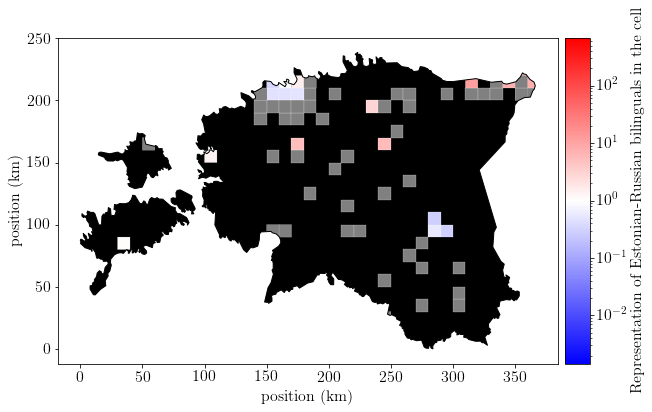

In [318]:
metric_dict = repr_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [319]:
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
cell_plot_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
        
cell_plot_df, grps_dict = metrics.calc_by_cell(
    cell_plot_df, grps_dict, cell_size=cell_size)

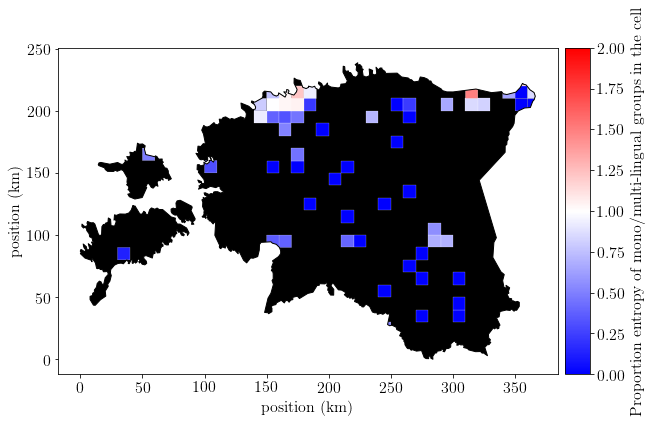

In [320]:
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/multi-lingual groups'}}
metric_dict = Hp_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
helpers_viz.metric_grid(
    cell_plot_df, metric_dict, shape_df, mono_multi_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    min_count=5, null_color='k')

possibility: (i) how are multilinguals distributed wrt local pop, and then (ii) how mixed are monolinguals

(i): test KL divergence of multiling (summing counts of all bi-trilinguals) from local count. Pb: when too few multilinguals overall, poor results because of cells with multiling_count == 0. Can also try Hc and distribution tests. Way to measure how complementary multilinguals are to monolinguals? like compare to 1-mono

(ii): take one of the entropies, or sort of weighted average (weighted how?) of in-between groups distribution divergences, or weighted average of divergences between langs and local (total?) pop

maybe fractal dimension (-> if close to 1, means biliguals on border, on a line)?  use more the proportions for ling groups, and try fabio like entropy that could work well here


High entropy (so high diversity) where high prop of multilinguals/at the borders between monolinguals?

## Composite plots

In [269]:
min_count = 5
plot_config = {}
cases_dict = {
    'gal': {'cc': 'ES', 'region': 'Galicia', 'cell_size': 10000},
    'val': {'cc': 'ES', 'region': 'Valencian Community', 'cell_size': 10000},
    'bal': {'cc': 'ES', 'region': 'Balearic islands', 'cell_size': 5000},
    'bas': {'cc': 'ES', 'region': 'Basque country', 'cell_size': 5000},
}
for case in cases_dict.values():
    cc = case['cc']
    region = case.get('region')
    cell_size = case['cell_size']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
    if cc == 'BE':
        shapefile_path = os.path.join(
            external_data_dir, 'Apn_AdRe.shp', 'Apn_AdRe.shp')
        shape_df = geopd.read_file(shapefile_path)
        shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                     min_area=10**4, simplify_tol=50)
    else:
        shapefile_path = os.path.join(
            external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
        shape_df = geopd.read_file(shapefile_path)
        min_poly_area = area_dict.get('min_poly_area')
        shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                     min_area=min_poly_area)

    cell_data_path = cell_data_path_format.format(
        'users_cell_data', cc, area_name, cell_size, 'geojson')
    cell_plot_df = geopd.read_file(cell_data_path)
    cell_plot_df.index = cell_plot_df['cell_id']
    cell_plot_df, plot_langs_dict = metrics.calc_by_cell(
        cell_plot_df, plot_langs_dict, cell_size=cell_size)
    cell_plot_df, plot_lings_dict = metrics.calc_by_cell(
        cell_plot_df, plot_lings_dict, cell_size=cell_size)

    cell_plot_df = cell_plot_df.loc[cell_plot_df['total_count'] > min_count]
    grps_dict = plot_langs_dict
    list_grps = list(grps_dict.keys())
    init_len = len(plot_config)
    for k in range(len(grps_dict)):
        plot_config[k+init_len] = {
            'cell_plot_df': cell_plot_df.copy(), 'shape_df': shape_df, 
            'metric_dict': prop_dict, 'xy_proj': xy_proj,
            'grps_dict': grps_dict, 'grp': list_grps[k]}

    grps_dict = plot_multi_mono_dict
    count_col = 'multi_count'
    cell_plot_df[count_col] = 0
    for ling, ling_dict in plot_lings_dict.items():
        if len(ling.split('_')[1]) > 2:
            cell_plot_df[count_col] += cell_plot_df[ling_dict['count_col']]
    cell_plot_df, grps_dict = metrics.calc_by_cell(
        cell_plot_df, grps_dict, cell_size=cell_size)
    mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}
    new_len = len(plot_config)
    plot_config[new_len] = {
        'cell_plot_df': cell_plot_df, 'shape_df': shape_df, 
        'metric_dict': Hp_dict, 'xy_proj': xy_proj,
        'grps_dict': mono_multi_lings_dict, 'grp': 'mono-multi'}

In [270]:
annotate_kwargs = {'fontfamily': 'Helvetica', 'fontsize': 14,
                   'usetex': False}
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.1, 'cmap': 'plasma'}
annotations = [chr(i).upper() for i in range(ord('a'), ord('z')+1)]

axes_dict = {}
for i, config in plot_config.items():
    ax_dict = {'figsize': (15/2.54, 10), 'borderwidth': 0.2,
               'cbar_lw': 0, 'annotation': annotations[i],
               'xy_proj': config['xy_proj'], 'annotate': annotate_kwargs,
               'plot': plot_kwargs.copy()}
    axes_dict[i] = helpers_viz.axis_config(ax_dict, config, min_count=min_count)

In [156]:
plt.rc('font', size=7)

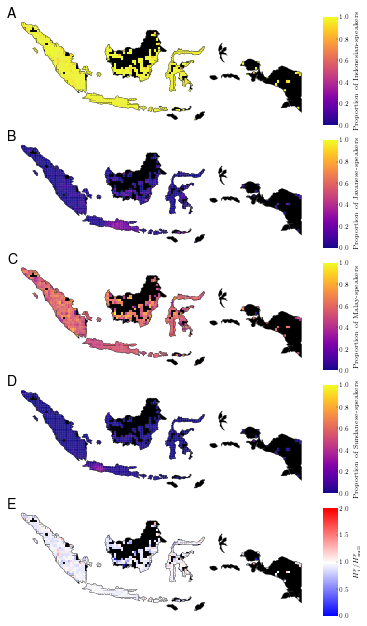

In [242]:
nr_rows = 4
nr_cols = 3
fig, axes = plt.subplots(nr_rows, nr_cols, figsize=(13/2.54, 25/2.54))
for i, ax in enumerate(axes.flatten()):
#     i += nr_cols*3
    cell_plot_df = plot_config[i]['cell_plot_df']
    shape_df = plot_config[i]['shape_df']
    fig, ax = grid_viz.plot_grid(cell_plot_df, shape_df, ax=ax, fig=fig,
                                 **axes_dict[i])
fig.tight_layout(h_pad=-10, w_pad=0)
fig.savefig(os.path.join(fig_dir, cc, 'twitter_data_ID.pdf'), bbox_inches='tight')
fig.show()

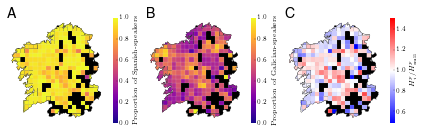

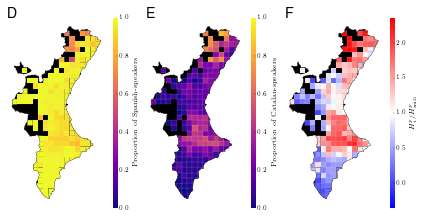

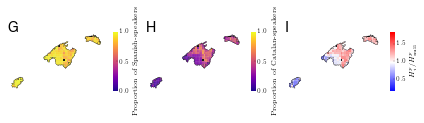

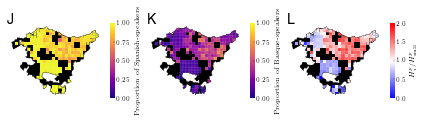

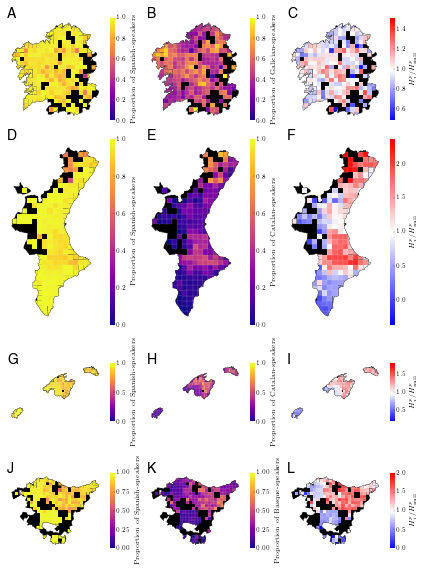

In [332]:
nr_rows = 4
nr_cols = 3
figsize = (15/2.54, 25/2.54)
h_pad = 2 # in fraction of font size
save_path = os.path.join(fig_dir, cc, 'twitter_data_add_ES.pdf')
fig, axes = helpers_viz.tighth_compos_grids(
    plot_config, axes_dict, nr_rows=nr_rows, nr_cols=nr_cols, figsize=figsize,
    h_pad=2, save_path=save_path)

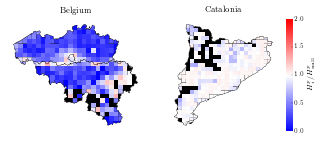

In [96]:
fig = plt.figure(figsize=(12/2.54, 5/2.54), constrained_layout=False)
gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 0.05])
axes = gs.subplots()
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.01,
               'cmap': 'bwr'}
cbar_labels = [None, Hp_dict['cbar_label']]
regions = (('BE', None), ('ES', 'Catalonia'))
plot_iter = zip(axes[:-1], cbar_labels, regions)
for c_idx, (ax, cbar_label, r) in enumerate(plot_iter):
    cc = r[0]
    region = r[1]
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
    if cc == 'BE':
        shapefile_path = os.path.join(
            external_data_dir, 'Apn_AdRe.shp', 'Apn_AdRe.shp')
        shape_df = geopd.read_file(shapefile_path)
        shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                     min_area=10**4, simplify_tol=50)
    else:
        shapefile_path = os.path.join(
            external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
        shape_df = geopd.read_file(shapefile_path)
        min_poly_area = area_dict.get('min_poly_area')
        shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                     min_area=min_poly_area)
    cell_df_path = cell_data_path_format.format(
        'users_cell_data', cc, area_dict['readable'], 10000, 'geojson')
    cell_plot_df = geopd.read_file(cell_df_path)
    cell_plot_df.index = cell_plot_df['cell_id']
    cell_plot_df = cell_plot_df.loc[cell_plot_df['local_count'] > 5]
    cell_plot_df, _ = metrics.calc_by_cell(cell_plot_df, plot_lings_dict, cell_size=cell_size)
    
    fig, ax = grid_viz.plot_grid(
        cell_plot_df, shape_df, metric_col='Hp', ax=ax, fig=fig, xy_proj=area_dict['xy_proj'],
        cbar_label=cbar_label, cbar_lw=0, vmin=0, vmax=2, cax=axes[-1],
        show_axes=False, borderwidth=0.2, **{'plot': plot_kwargs})
    ax.set_title(area_dict['readable'])
    
save_path = os.path.join(fig_dir, 'all', 'Hp_BE_vs_CAT.pdf')
fig.savefig(save_path, bbox_inches='tight')
fig.show()

# Countries "phase space"

In [327]:
save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
countries_dict = {
    'Uruguay': {'cc': 'UY', 'region': None, 'cell_sizes': [20000]},
    'Paraguay': {'cc': 'PY', 'region': None, 'cell_sizes': [30000, 40000]},
    'Cyprus': {'cc': 'CY', 'region': None, 'cell_sizes': [5000, 10000]},
    'Luxembourg': {'cc': 'LU', 'region': None, 'cell_sizes': [2000, 5000]},
    'Algeria': {'cc': 'DZ', 'region': None, 'cell_sizes': [40000, 60000]},
    'Morocco': {'cc': 'MA', 'region': None, 'cell_sizes': [20000, 40000]},
    'Finland': {'cc': 'FI', 'region': None, 'cell_sizes': [40000]},
#     'SG': {'region': None, 'cell_sizes': [1000, 2000]},
    'Switzerland': {'cc': 'CH', 'region': None, 'cell_sizes': [10000, 15000]},
    'Belgium': {'cc': 'BE', 'region': None, 'cell_sizes': [5000, 10000, 15000]},
    'Catalonia': {'cc': 'ES', 'region': 'Catalonia', 'cell_sizes': [5000, 10000, 15000]},
    'Balearic islands': {'cc': 'ES', 'region': 'Balearic islands', 'cell_sizes': [5000, 10000]},
    'Galicia': {'cc': 'ES', 'region': 'Galicia', 'cell_sizes': [10000]},
    'Valencian Community': {'cc': 'ES', 'region': 'Valencian Community', 'cell_sizes': [5000, 10000]},
    'Basque country': {'cc': 'ES', 'region': 'Basque country', 'cell_sizes': [5000, 10000]},
    'Latvia': {'cc': 'LV', 'region': None, 'cell_sizes': [10000]},
    'Estonia': {'cc': 'EE', 'region': None, 'cell_sizes': [10000]},
#     'Florida': {'cc': 'US', 'region': 'Florida', 'cell_sizes': [20000]},
#     'Louisiana': {'cc': 'US', 'region': 'Louisiana', 'cell_sizes': [20000]},
#     'Texas': {'cc': 'US', 'region': 'Texas', 'cell_sizes': [20000]},
#     'New Mexico': {'cc': 'US', 'region': 'New Mexico', 'cell_sizes': [20000]},
#     'Arizona': {'cc': 'US', 'region': 'Arizona', 'cell_sizes': [20000]},
#     'Nevada': {'cc': 'US', 'region': 'Nevada', 'cell_sizes': [20000]},
#     'California': {'cc': 'US', 'region': 'California', 'cell_sizes': [20000]},
    'Quebec': {'cc': 'CA', 'region': 'Quebec', 'cell_sizes': [20000]},
    'Malaysia': {'cc': 'MY', 'region': None, 'cell_sizes': [20000]},
    'Indonesia': {'cc': 'ID', 'region': None, 'cell_sizes': [40000]},
}

In [71]:
with open(save_path) as f:
    data_countries_dict = json.load(f)

## Metric calc

In [328]:
# data_countries_dict = {}
with open(save_path) as f:
    data_countries_dict = json.load(f)
for _, cc_dict in countries_dict.items():
    region = cc_dict['region']
    cc = cc_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)

    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    shapefile_path = os.path.join(
        external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
    shape_df = geopd.read_file(shapefile_path)
    min_poly_area = area_dict.get('min_poly_area')
    shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                 min_area=min_poly_area)
    
    for cell_size in cc_dict['cell_sizes']:
        case_name = f'{area_name}{cell_size/1000:.0f}'
        case_dict = data_countries_dict.get(case_name, {})
        case_dict['name'] = case_name
        print(f'-- {case_name}')
        d_matrix = None
        _, _, Nx, Ny = geo.create_grid(
            shape_df, cell_size, xy_proj=xy_proj, intersect=False)
        cell_data_path = cell_data_path_format.format(
            'users_cell_data', cc, area_name, cell_size, 'geojson')
        cell_plot_df = geopd.read_file(cell_data_path)
        cell_plot_df.index = cell_plot_df['cell_id']
        real_cell_size = (cell_plot_df.area)**0.5 ## CHANGED HERE
        
        grps_dict = plot_langs_dict
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['Hc_langs'], grps_dict = metrics.all_grps_metric(
            Hc_dict, cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['KL_langs'], grps_dict = metrics.all_grps_metric(
            KL_dict, cell_plot_df, grps_dict)
    
    
        N = sum([cell_plot_df[f'count_{grp}'].sum() for grp in grps_dict])
        case_dict['EMD_langs'] = 0
        for grp, grp_dict in plot_langs_dict.items():
            N_grp = cell_plot_df[grp_dict['count_col']].sum()
            grp_label = grp_dict['grp_label']
            emd_value, norm, d_matrix = metrics.earthmover_distance(
                cell_plot_df, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
            case_dict[f'EMD_{grp}_vs_tot'] = emd_value/norm
            case_dict['EMD_langs'] += N_grp/N * emd_value/norm
        
        case_dict['EMD_lang_vs_lang'] = 0
        langs_done = []
        nr_grps = len(plot_langs_dict)
        for grp, grp_dict in plot_langs_dict.items():
            N_grp = cell_plot_df[grp_dict['count_col']].sum()
            for other_grp, other_grp_dict in plot_langs_dict.items():
                if (grp != other_grp) and (other_grp not in langs_done):
                    N_other_grp = cell_plot_df[other_grp_dict['count_col']].sum()
                    emd_value, norm, d_matrix = metrics.earthmover_distance(
                        cell_plot_df, grp_dict['conc_col'], other_grp_dict['conc_col'], d_matrix=d_matrix)
                    case_dict['EMD_lang_vs_lang'] += (
                        (N_grp+N_other_grp) / (N*(nr_grps-1)) * emd_value/norm)
            langs_done.append(grp)

        grps_dict = plot_multi_mono_dict
        count_col = 'multi_count'
        cell_plot_df[count_col] = 0
        for ling, ling_dict in plot_lings_dict.items():
            ling_count_col = ling_dict['count_col']
            if (len(ling.split('_')[1]) > 2 and 
                    ling_count_col in cell_plot_df.columns):
                cell_plot_df[count_col] += cell_plot_df[ling_count_col]
        cell_plot_df, grps_dict = metrics.calc_by_cell(
            cell_plot_df, grps_dict, cell_size=real_cell_size)
        prop_null = (cell_plot_df.loc[cell_plot_df[count_col] == 0].shape[0] 
                     / cell_plot_df.shape[0])
        print(f"The ratio of cells with a null multilinguals' count is {prop_null}")
        for grp, grp_dict in grps_dict.items():
            count_col = grp_dict['count_col']
            conc_col = grp_dict['conc_col']
            n_samples = cell_plot_df[count_col].sum()
            ks_score, p_value = metrics.ks_test_2d(cell_plot_df, conc_col, 
                                                   'total_conc', Nx, Ny, n_samples)
            grp_dict['KS'] = {'score': ks_score, 'p_value': p_value}
            grps_dict[grp] = grp_dict

        case_dict['Hp_mono_multi'] = metrics.all_cells_metric(Hp_dict, cell_plot_df)
        case_dict['Hc_mono_multi'], grps_dict = metrics.all_grps_metric(
            Hc_dict, cell_plot_df, grps_dict, cell_size=real_cell_size)
        case_dict['KL_mono_multi'], grps_dict = metrics.all_grps_metric(
            KL_dict, cell_plot_df, grps_dict)
        
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            cell_plot_df, grps_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
        case_dict['EMD_multi'] = emd_value / norm
            
        case_dict['KS_multi'] = grps_dict['multi']['KS']['score']
        data_countries_dict[case_name] = case_dict

-- Switzerland40
5.1802084822598 5.310899553411885
The Concentration entropy for the German-speakers is: 0.024608085661896095.
4.4887863495113995 5.307818885625572
The Concentration entropy for the French-speakers is: 0.1543067979075632.
4.531572929059253 5.303060676038026
The Concentration entropy for the Italian-speakers is: 0.14547971334077958.
The Concentration entropy averaged over all groups is 0.09153029049458009.
The KL divergence for the German-speakers is: 0.5881151164896996.
The KL divergence for the French-speakers is: 0.8973778209063811.
The KL divergence for the Italian-speakers is: 1.6797167780886098.
The KL divergence averaged over all groups is 0.520782500770621.
The ratio of cells with a null multilinguals' count is 0.18181818181818182
The Relative proportion entropy averaged over all cells is 0.5415231410186911
5.142383007031002 5.3108936249943985
The Concentration entropy for the German monolinguals is: 0.03172923990989829.
4.408349284947389 5.307521599002406
The Co

In [78]:
save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
json_file = json.dumps(data_countries_dict)
with open(save_path, 'w') as f:
    f.write(json_file)

## Plot

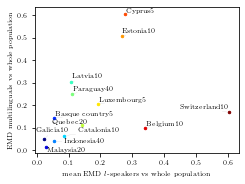

In [343]:
with open(save_path) as f:
    data_countries_dict = json.load(f)

# cases_to_include = ['Balearic islands5', 'Balearic islands10', 'Galicia5', 
#                     'Galicia10', 'Valencian Community5', 'Valencian Community10',
#                     'Basque country5', 'Basque country10']
cases_to_include = [
    'Galicia10', 'Basque country5',
    'Switzerland10', 'Belgium10', 'Catalonia10',
    'Malaysia20', 'Indonesia40', 'Quebec20',
    'Latvia10', 'Estonia10', 'Cyprus5', 'Luxembourg5', 'Paraguay40']
plot_countries_dict = {
    case_name: case_dict for case_name, case_dict in data_countries_dict.items()
    if case_name in cases_to_include}
#     if case_name not in cases_to_exclude}
langs_metric = 'EMD_langs'
# langs_metric_label = 'EMD lang vs lang'
langs_metric_label = r'mean EMD $l$-speakers vs whole population'
multiling_metric = 'EMD_multi'
multiling_metric_label = 'EMD multilinguals vs whole population'
region_to_del = []
for region, region_dict in plot_countries_dict.items():
    if (region_dict[langs_metric] is None) or (region_dict[multiling_metric] is None):
        region_to_del.append(region)
for region in region_to_del:
    del plot_countries_dict[region]
        
countries = [case_dict['name'] for case_dict in plot_countries_dict.values()]
lang_metrics = [case_dict[langs_metric] for case_dict in plot_countries_dict.values()]
multi_metrics = [case_dict[multiling_metric] 
                 for case_dict in plot_countries_dict.values()]
file_path = os.path.join(fig_dir, 'all', 
                         f'phase_space_{langs_metric}_vs_{multiling_metric}_others.pdf')
fig, ax = helpers_viz.scatter_labelled(
    lang_metrics, multi_metrics, countries, xlabel=langs_metric_label,
    ylabel=multiling_metric_label, figsize=None, save_path=file_path,
    **{'adj_text': {'expand_text': (1.05, 1.2), 'expand_points': (1.05, 1.5), 'only_move': {'points': 'xy', 'text': 'xy', 'objects': 'xy'}}})

Cell size invariance

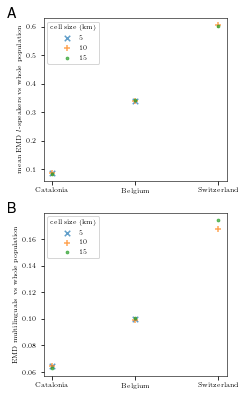

In [153]:
with open(save_path) as f:
    data_countries_dict = json.load(f)

fig, axes = plt.subplots(2, 1, figsize=(8.7/2.54, 14/2.54))
xticks = np.array([1, 2, 3])
EMD_names = ('EMD_langs', 'EMD_multi')
ylabels = (r'mean EMD $l$-speakers vs whole population', 
           'EMD multilinguals vs whole population')
annotations = ('A', 'B')
for ax, ylabel, EMD, annotation in zip(axes, ylabels, EMD_names, annotations):
#     _, ax = plt.subplots(2, 1, figsize=(8.7/2.54, 14/2.54))
    p1 = ax.scatter(
        xticks[:-1], 
        [data_countries_dict['Catalonia5'][metric],
         data_countries_dict['Belgium5'][metric]],
        alpha=0.7,
        label='5',
        marker='x', s=30)
    p2 = ax.scatter(
        xticks,
        [data_countries_dict['Catalonia10'][metric],
         data_countries_dict['Belgium10'][metric],
         data_countries_dict['Switzerland10'][metric]],
        alpha=0.7,
        label='10',
        marker='+', s=30)

    p3 = ax.scatter(
        xticks,
        [data_countries_dict['Catalonia15'][metric],
         data_countries_dict['Belgium15'][metric],
         data_countries_dict['Switzerland15'][metric]],
        alpha=0.7,
        label='15',
        marker='.', s=30)#, facecolors='none', edgecolors='g')
    ax.set_xticks(xticks)
    ax.set_xticklabels(('Catalonia', 'Belgium', 'Switzerland'))
    ax.set_ylabel(ylabel)
    ax.legend(title='cell size (km)')
    ax.annotate(annotation, (-0.2, 1), xycoords='axes fraction',
                **annotate_kwargs)
fig.set_tight_layout(True)
# plt.tight_layout()
fig.savefig(os.path.join(fig_dir, 'all', 'EMD_cell_size_invariance.pdf'))
fig.show()

## Generate local counts

In [ ]:
save_path = os.path.join(processed_data_dir, 'plot_countries_dict.json')
countries_dict = {
    'Paraguay': {'cc': 'PY', 'region': None, 'cell_sizes': [40000]},
    'Cyprus': {'cc': 'CY', 'region': None, 'cell_sizes': [5000]},
    'Finland': {'cc': 'FI', 'region': None, 'cell_sizes': [40000]},
    'Switzerland': {'cc': 'CH', 'region': None, 'cell_sizes': [10000]},
    'Belgium': {'cc': 'BE', 'region': None, 'cell_sizes': [10000]},
    'Catalonia': {'cc': 'ES', 'region': 'Catalonia', 'cell_sizes': [10000]},
    'Balearic islands': {'cc': 'ES', 'region': 'Balearic islands', 'cell_sizes': [5000]},
    'Galicia': {'cc': 'ES', 'region': 'Galicia', 'cell_sizes': [10000]},
    'Valencian Community': {'cc': 'ES', 'region': 'Valencian Community', 'cell_sizes': [10000]},
    'Basque country': {'cc': 'ES', 'region': 'Basque country', 'cell_sizes': [5000]},
    'Latvia': {'cc': 'LV', 'region': None, 'cell_sizes': [10000]},
    'Estonia': {'cc': 'EE', 'region': None, 'cell_sizes': [10000]},
    'Quebec': {'cc': 'CA', 'region': 'Quebec', 'cell_sizes': [20000]},
    'Malaysia': {'cc': 'MY', 'region': None, 'cell_sizes': [20000]},
    'Indonesia': {'cc': 'ID', 'region': None, 'cell_sizes': [40000]},
}

with open(save_path) as f:
    data_countries_dict = json.load(f)
local_counts_dict = {}
for _, cc_dict in countries_dict.items():
    region = cc_dict['region']
    cc = cc_dict['cc']
    area_dict = make_config.area_dict(countries_study_data, cc, region=region)
    xy_proj = area_dict['xy_proj']
    area_name = area_dict['readable']
    plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
    plot_lings_dict = make_config.linguals_dict(area_dict)
    plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)

    shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    shapefile_path = os.path.join(
        external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
    shape_df = geopd.read_file(shapefile_path)
    min_poly_area = area_dict.get('min_poly_area')
    shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                                 min_area=min_poly_area)
    
    for cell_size in cc_dict['cell_sizes']:
        case_name = f'{area_name}{cell_size/1000:.0f}'
        case_dict = data_countries_dict.get(case_name, {})
        case_dict['name'] = case_name
        print(f'-- {case_name}')
        d_matrix = None
        _, _, Nx, Ny = geo.create_grid(
            shape_df, cell_size, xy_proj=xy_proj, intersect=False)
        cell_data_path = cell_data_path_format.format(
            'users_cell_data', cc, area_name, cell_size, 'geojson')
        cell_plot_df = geopd.read_file(cell_data_path)
        cell_plot_df.index = cell_plot_df['cell_id']
        local_counts_dict[area_name] = cell_plot_df['local_count'].sum()
        
out = pd.Series(local_counts_dict)
out = out.rename('countlocals')
out.index = out.index.rename('regionname')
out = out.astype(int)
out.to_csv(os.path.join(processed_data_dir, 'count_locals.csv'))